In [1]:
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from jax import disable_jit, random
from numpyro.infer import HMC, MCMC, NUTS, DiscreteHMCGibbs, HMCGibbs, Predictive
from numpyro.util import control_flow_prims_disabled, optional


def model(probs, locs):
    c = numpyro.sample("c", dist.Categorical(probs))
    numpyro.sample("x", dist.Normal(locs[c], jnp.sqrt(0.1)))


probs = jnp.array([0.15, 0.3, 0.3, 0.25])
locs = jnp.array([-2, 0, 2, 4])
predictive = Predictive(model, {}, num_samples=int(1e7), return_sites=["x"])
actual_samples = predictive(random.PRNGKey(1), probs, locs)["x"]

In [8]:
%%time
inner_kernel = NUTS(model)
kernel = DiscreteHMCGibbs(NUTS(model), modified=True)
mcmc = MCMC(kernel, 1000, int(1e6), progress_bar=False)
mcmc.run(random.PRNGKey(0), probs, locs)
mcmc.print_summary()
x_samples = mcmc.get_samples()["x"]
assert abs(jnp.mean(x_samples) - 1.3) < 0.1
assert abs(jnp.var(x_samples) - 4.36) < 0.5


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         c      1.66      1.00      2.00      0.00      3.00    551.24      1.00
         x      1.33      2.02      1.71     -2.04      4.33    564.43      1.00

CPU times: user 6.14 s, sys: 31.8 ms, total: 6.17 s
Wall time: 6.11 s


In [7]:
%%time
from numpyro.infer.mixed_hmc import MixedHMC

inner_kernel = HMC(model, step_size=0.6, trajectory_length=20 * 0.6)
kernel = MixedHMC(inner_kernel, num_trajectories=20)
mcmc = MCMC(kernel, 1000, int(1e6), progress_bar=False)
debug = False
with optional(debug, disable_jit()), optional(debug, control_flow_prims_disabled()):
    mcmc.run(random.PRNGKey(0), probs, locs)
mcmc.print_summary()
x_samples = mcmc.get_samples()["x"]
assert abs(jnp.mean(x_samples) - 1.3) < 0.1
assert abs(jnp.var(x_samples) - 4.36) < 0.5


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         c      1.68      1.01      2.00      0.00      3.00   5192.67      1.00
         x      1.36      2.04      1.74     -2.03      4.35   5309.70      1.00

CPU times: user 26.8 s, sys: 61.5 ms, total: 26.9 s
Wall time: 26.8 s


In [3]:
%%time
from numpyro.infer.mixed_hmc import MixedHMCGibbs

kernel = MixedHMCGibbs(NUTS(model), num_trajectories=1)
mcmc = MCMC(kernel, 1000, int(1e6), progress_bar=False)
debug = False
with optional(debug, disable_jit()), optional(debug, control_flow_prims_disabled()):
    mcmc.run(random.PRNGKey(2), probs, locs)
mcmc.print_summary()
x_samples = mcmc.get_samples()["x"]
assert abs(jnp.mean(x_samples) - 1.3) < 0.1
assert abs(jnp.var(x_samples) - 4.36) < 0.5

step Traced<ShapedArray(int32[])>with<DynamicJaxprTrace(level=2/0)> : Traced<ShapedArray(float32[1])>with<DynamicJaxprTrace(level=2/0)> Traced<ShapedArray(float32[1])>with<DynamicJaxprTrace(level=2/0)>

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         c      1.65      1.02      2.00      0.00      3.00    446.00      1.00
         x      1.30      2.06      1.69     -2.06      4.34    455.81      1.00

CPU times: user 7.23 s, sys: 69.7 ms, total: 7.3 s
Wall time: 7.24 s


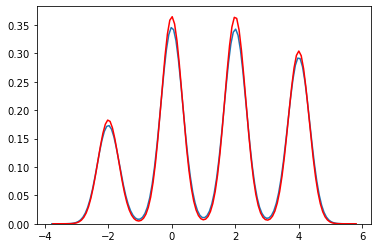

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.kdeplot(x_samples.reshape(-1).copy())
sns.kdeplot(actual_samples.copy(), color="r");